# A PyTorch Implementation of Algorithms in Optimal and Adaptive Algorithms for Online Boosting

## Dependencies: 
PyTorch, matplotlib, numpy

## Implementation Note

I consider labels of the form {0, 1} and cast to {-1, +1} where needed. This may not be appropriate or necessary, and may be changed in the future.

## Todo:

I want to modularize this further by adjusting how we accept data.

So with regards to data, I also want to change the labels to {-1, +1} by default instead of this stupid converting from {0, 1} process. ---> Not possible :(

## Setup

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

transform = transforms.Compose(
   [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# get CIFAR10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes = ('cat', 'dog', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# create binary dataset 
label1 = 3; label2 = 5 # change if desired
trainset.train_labels = np.array(trainset.train_labels)
testset.test_labels = np.array(testset.test_labels)

# adjust train set
mask = (trainset.train_labels == label1) | (trainset.train_labels == label2)
trainset.train_data=trainset.train_data[mask]
trainset.train_labels=trainset.train_labels[mask]
mask1 = (trainset.train_labels == label1)
mask2 = (trainset.train_labels == label2)
trainset.train_labels[mask1] = 0
trainset.train_labels[mask2] = 1

# adjust test set
mask = (testset.test_labels == label1) | (testset.test_labels == label2)
testset.test_data=testset.test_data[mask]
testset.test_labels=testset.test_labels[mask]
mask1 = (testset.test_labels == label1)
mask2 = (testset.test_labels == label2)
testset.test_labels[mask1] = 0
testset.test_labels[mask2] = 1

# load datasets for experiments: 1 at a time for training; 8 at a time for testing
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)

print("Data loaded:")
print("- Training set size:", len(trainset))
print("- Test set size:", len(testset))

Files already downloaded and verified
Files already downloaded and verified
Data loaded:
- Training set size: 10000
- Test set size: 2000


In [2]:
import matplotlib.pyplot as plt

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(testloader)
images = []; labels = []
img_count = 8
for _ in range(img_count):
    image, label = dataiter.next()
    images.append(image)
    labels.append(label)
images = torch.from_numpy(np.concatenate(images, 0))
labels = torch.from_numpy(np.concatenate(labels, 0))

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(img_count)))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


<Figure size 640x480 with 1 Axes>

  cat   cat   dog   dog   dog   dog   dog   dog


In [3]:
# neural net
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.fc1(x)
        return x

class Net_zero(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.fc1 = nn.Linear(6 * 5 * 5, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.fc1(x)
        return x

In [4]:
# loss to use
criterion = nn.CrossEntropyLoss()   

# binomial helper function
def binom(a, b):
    return np.math.factorial(a) / (np.math.factorial(a-b) * np.math.factorial(b))

# get output of weak learner i
# o.w. get output of combination of WLs    
def predict_WL(weak_learners, x, i=0):
    with torch.no_grad():
        net, _ = weak_learners[i]
        output = net(x)
        _, predict = torch.max(output.data, 1)
        return predict

# update weak learner i
def update_WL(weak_learners, x, y, i):
    net, optimizer = weak_learners[i]
    optimizer.zero_grad()
    output = net(x)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    
# get output of combination of WLs (unweighted)
def predict_WL_alg1(weak_learners, x):    
    N = len(weak_learners)
    prediction = 0
    for i in range(N):
        prediction += predict_WL(weak_learners, x, i)
    return 0 if (prediction < N/2) else 1

# get output of combination of WLs (weighted)
def predict_WL_alg2(weak_learners, x, alpha, i):
    N = len(weak_learners)
    prediction = 0
    for j in range(0, i+1):
        prediction += alpha[j] * (2 * predict_WL(weak_learners, x, j) - 1)
    return 0 if (np.sign(prediction) < 0) else 1

In [5]:
# algorithm 0: online weak learner
def baseline(weak_learner):
    
    # keep track of metrics every 100 iterations
    n_mistakes = 0    
    n_mistakes_over_time = []
    
    # training
    net, optimizer = weak_learner    
    for t, data in enumerate(trainloader, 1):
        x, y = data        
        optimizer.zero_grad()
        output = net(x)        
        loss = criterion(output, y)
        _, predict = torch.max(output.data, 1)
        loss.backward()
        optimizer.step()
        
        n_mistakes += (predict != y).item()
        if t % 100 == 0:
            n_mistakes_over_time.append(n_mistakes)
    
    return np.array(n_mistakes_over_time)

# Online BBM 

In [33]:
def onlineBBM(weak_learners, T):

    # keep track of metrics every 100 iterations
    n_mistakes = 0    
    n_mistakes_over_time = []
    
    # parameters
    gamma = 0.1    
    N = len(weak_learners)
    s = np.zeros(N+1)
    k = np.zeros(N+1)
    w = np.zeros(N+1)
    max_w = np.zeros(N+1)
    
    # T loop
    for t, data in enumerate(trainloader, 0):
        
        # perform T iterations
        if t >= T: 
            print("Fraction of mistakes at the end of training:", n_mistakes / (T))
            break
        
        # receive example and label
        x, y = data        
        
        # predict y
        y_hat = predict_WL_alg1(weak_learners, x)        
        
        # N loop
        for j in range(1,N+1):
            
            # update values
            s[j] = s[j-1] + (2*y - 1) * predict_WL(weak_learners, x, j-1)
            k[j] = np.floor((N - j - s[j-1] + 1)/2)
            binom_term = 0 if (k[j] < 0 or k[j] > N - j) else binom(N-j, k[j])
            w[j] = binom_term * np.power(1/2 + gamma/2, k[j]) * np.power(1/2 - gamma/2, N - j - k[j])
            max_w[j] = max(w[j], max_w[j])            
            
            # pass training example to WL j with some probability  
            prob = 0 if max_w[j] == 0 else w[j]/max_w[j]
            if np.random.random_sample() < w[j]/max_w[j]: # what to take max over
                update_WL(weak_learners, x, y, j-1)
                
        # evaluate mistakes
        n_mistakes += (y_hat != y).item()
        if (t+1) % 50 == 0:
            n_mistakes_over_time.append(n_mistakes)
        if (t+1) % 1000 == 0:
            print("Fraction of mistakes by time %d" % (t+1), n_mistakes / (t+1))
                
    return n_mistakes_over_time

# AdaBoost OL

In [34]:
def adaboostOL(weak_learners, T):
    
    # keep track of metrics every 100 iterations
    n_mistakes = 0    
    n_mistakes_over_time = []
    
    # parameters
    N = len(weak_learners)    
    v = np.ones(N)
    alpha = np.zeros(N)
    y_hat = np.zeros(N+1)
    z = np.zeros(N+1)
    s = np.zeros(N+1)
    
    # T loop
    for t, data in enumerate(trainloader, 0):
        
        # perform T iterations
        if t >= T: 
            print("Fraction of mistakes at the end of training:", n_mistakes / (T))
            break
        
        # receive example and label
        x, y = data
        
        # predict y wrt each WL
        for j in range(N):
            y_hat[j] = predict_WL_alg2(weak_learners, x, alpha, j)
            
        # model randomly chooses prediction of some WL
        v = v / np.sum(v)
        idx = np.random.choice(N, size=1, p=v)
        y_hat_final = y_hat[idx]
        
        # N loop
        for j in range(1,N+1):
            
            # set values
            z[j] = (2*y - 1) * predict_WL(weak_learners, x, j-1)
            s[j] = s[j-1] + alpha[j-1] * z[j]
            alpha[j-1] = max(-2, min(2, alpha[j-1] + (4 * z[j] / np.sqrt(t)) / (1 + np.exp(s[j]))))
            
            # pass training example to WL j with some probability
            if np.random.random_sample() < 1 / (1 + np.exp(s[j-1])):
                update_WL(weak_learners, x, y, j-1)
                
            # update v
            indic = -1 if (y_hat_final != y) else 0
            v[j-1] = v[j-1] * np.exp(indic)
            
        # evaluate mistakes
        n_mistakes += (y_hat_final != y).item()
        if (t+1) % 50 == 0:
            n_mistakes_over_time.append(n_mistakes)
        if (t+1) % 1000 == 0:
            print("Fraction of mistakes by time %d" % (t+1), n_mistakes / (t+1))
            
    return n_mistakes_over_time, alpha

In [27]:
import torch.optim as optim
import matplotlib.pyplot as plt

# plot variables
plt_interval = 50

# Enable GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("GPU is available.")

GPU is available.


## Evaluate Models on Test Set

In [28]:
def evaluate_WLs(weak_learners):
    print("EVALUATING WEAK LEARNERS")
    
    for i in range(len(weak_learners)):
        correct = 0
        with torch.no_grad():
            for data in testloader:
                x, y = data
                prediction = predict_WL(weak_learners, x, i)
                correct += (prediction == y).sum().item()
        print('Accuracy of weak learner', i, 'on the 2000 test images: %d %%' % (100 * correct / len(testloader)))
        
def evaluate_model_onlineBBM(weak_learners):
    print("\nEVALUATING MODEL")
    
    N = len(weak_learners)
    correct = 0
    with torch.no_grad():
        for data in testloader: 
            x, y = data
            prediction = predict_WL_alg1(weak_learners, x)
            correct += (prediction == y).sum().item()
    print('Accuracy of the network on the 2000 test images: %d %%' % (100 * correct / len(testloader)))
    
def evaluate_model_adaboostOL(weak_learners, alpha):
    print("\nEVALUATING MODEL")
    
    N = len(weak_learners)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            x, y = data
            prediction = predict_WL_alg2(weak_learners, x, alpha, N-1)
            correct += (prediction == y).sum().item()
    print('Accuracy of the network on the 2000 test images: %d %%' % (100 * correct / len(testloader)))

## Evaluate Models Online

In [39]:
def evaluate_baseline():
    print("Evaluating Baseline:")
    
    net = Net() 
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    weak_learner = (net, optimizer)
    mistakes = baseline(weak_learner)
    evaluate_WLs([weak_learner])
    
    # plot results
    plt.plot(mistakes/ np.arange(100, 10001, 100))
    plt.xlabel("Number of Iterations")
    plt.ylabel("Loss")
    plt.show()
    
def evaluate_onlineBBM(N, T):
    print("Evaluating Online BBM:")
    
    # initialize N weak learners
    weak_learners = []
    for _ in range(N):
        net = Net()    
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
        weak_learners.append((net, optimizer)) 
        
    # test
    mistakes = onlineBBM(weak_learners, T)
    print()
    evaluate_WLs(weak_learners)
    print()
    evaluate_model_onlineBBM(weak_learners)
    
    # plot results
    error_rates = mistakes/ np.arange(plt_interval, T+1, plt_interval)
    plt.plot(np.arange(plt_interval, T+1, plt_interval), error_rates)
    plt.xlabel("Number of Iterations")
    plt.ylabel("Loss")
    plt.show()
    
def evaluate_adaboostOL(N, T):
    print("Evaluating AdaBoost OL:")
    
    # initialize N weak learners
    weak_learners = []
    for _ in range(N):
        net = Net()    
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
        weak_learners.append((net, optimizer)) 
        
    mistakes, alpha = adaboostOL(weak_learners, T)
    print()
    evaluate_WLs(weak_learners)
    print()
    evaluate_model_adaboostOL(weak_learners, alpha)
    
    # plot results
    inputs = mistakes/ np.arange(plt_interval, T+1, plt_interval)
    plt.plot(inputs)
    plt.xlabel("Number of Iterations")
    plt.ylabel("Loss")
    plt.show()

## Baseline

EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 64 %


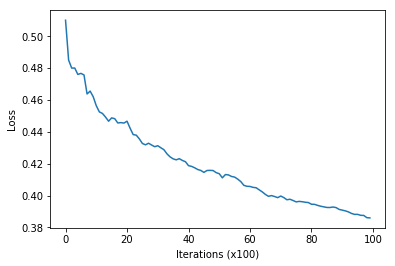

In [11]:
evaluate_baseline()

## Online BBM

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in double_scalars


Fraction of mistakes by time 1000 0.455
Fraction of mistakes by time 2000 0.4335
Fraction of mistakes by time 2000 0.4335
EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 62 %
Accuracy of weak learner 1 on the 2000 test images: 62 %
Accuracy of weak learner 2 on the 2000 test images: 61 %
Accuracy of weak learner 3 on the 2000 test images: 54 %
Accuracy of weak learner 4 on the 2000 test images: 58 %

EVALUATING MODEL
Accuracy of the network on the 2000 test images: 62 %


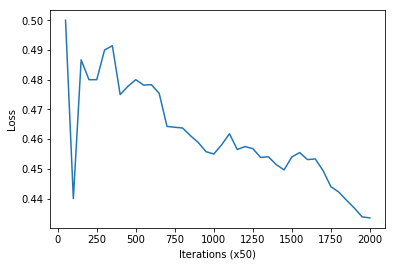

In [32]:
evaluate_onlineBBM(N=5, T=2000)

## Adaboost.OL

In [ ]:
evaluate_adaboostOL(N=5, T=100)

## Run Experiments

Evaluating AdaBoost OL:


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in double_scalars
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:41: RuntimeWarning: divide by zero encountered in double_scalars


Fraction of mistakes by time 1000 0.486
Fraction of mistakes at the end of training: 0.486

EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 50 %
Accuracy of weak learner 1 on the 2000 test images: 57 %
Accuracy of weak learner 2 on the 2000 test images: 52 %
Accuracy of weak learner 3 on the 2000 test images: 57 %
Accuracy of weak learner 4 on the 2000 test images: 50 %


EVALUATING MODEL
Accuracy of the network on the 2000 test images: 52 %


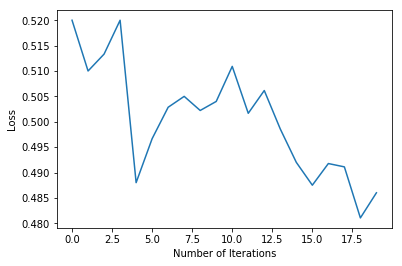

In [40]:
evaluate = [evaluate_onlineBBM, evaluate_adaboostOL]
nets = []
def run_experiment(T=10000, N=10, net=0, model=0):
    evaluate[model](N, T)
    
run_experiment(T=1000, N=5, model=1)

## Citations

Code for CNN: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Online algorithms: http://proceedings.mlr.press/v37/beygelzimer15.pdf